In [365]:
import numpy as np
nelems = 3  # Total number of elements
nnodes = 8  # Number of global nodes
dof_per_elem = 24
vars_per_node = 6
global_dofs = nnodes*vars_per_node

# Connectivity from local -> global
conn = [
    [0, 1, 2, 3], # Element 1 -> Global nodes 
    [2, 3, 4, 5], # Element 2 -> Global nodes
    [4, 5, 6, 7],
]

# Octo-garbonzo-mesh 
# nelems = 3  # Total number of elements
# nnodes = 8  # Number of global nodes
# dof_per_elem = 24
# vars_per_node = 6
# global_dofs = nnodes*vars_per_node

# # Connectivity from local -> global
# conn = np.random.randint(0, nnodes, size=(nelems, 4))

In [366]:
import numpy as np

# Create fake element stiffness matrix
def Kelem(ndof):
    return np.random.rand(ndof, ndof)


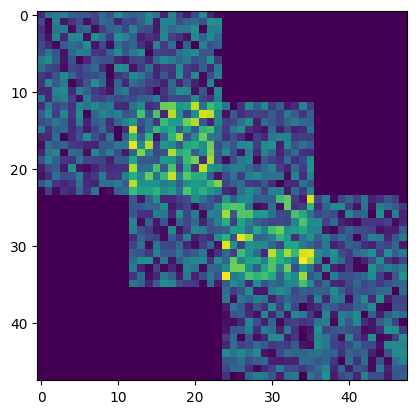

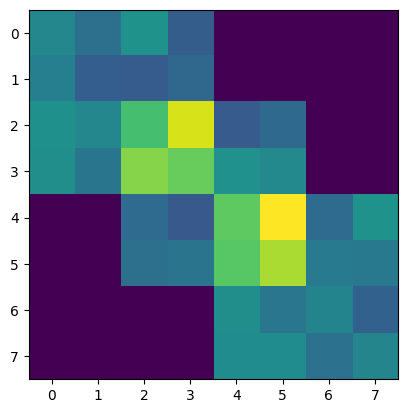

In [367]:
import matplotlib.pyplot as plt

# Assemble dense matrix
dense = np.zeros((global_dofs, global_dofs))
Kelem_list = [Kelem(dof_per_elem) for i in range(nelems)]

for i in range(nelems):
    Kelem_i = Kelem_list[i]
    local_node_conn = conn[i]

    local_dof_conn = [[vars_per_node*inode + idof for idof in range(6)] for inode in local_node_conn]
    local_dof_conn = np.array(local_dof_conn).flatten()

    global_ind = np.ix_(local_dof_conn, local_dof_conn)
    dense[global_ind] += Kelem_i


dense_nodal = np.zeros((nnodes, nnodes))
for i in range(nelems):
    Kelem_i = np.random.rand(4,4) + 1
    local_node_conn = np.array(conn[i])

    global_ind = np.ix_(local_node_conn, local_node_conn)
    dense_nodal[global_ind] += Kelem_i

plt.imshow(dense)
plt.show()
plt.imshow(dense_nodal)
plt.show()
    

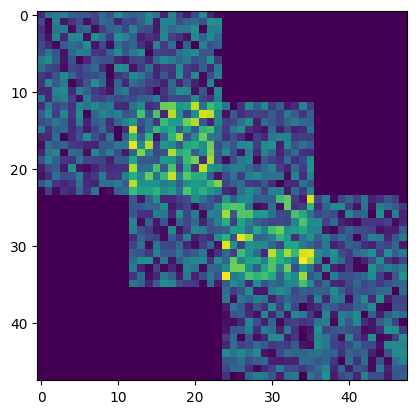

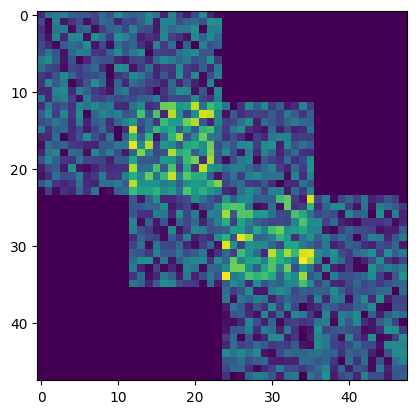

In [368]:
from scipy.sparse import bsr_matrix
# Sparse matrix
blockDim = vars_per_node
mb = nnodes
nnzb = 40

rowPtr = [0, 4, 8, 14, 20, 26, 32, 36, 40]
colPtr = [0, 1, 2, 3] * 2 + [0, 1, 2, 3, 4, 5] * 2 + [2, 3, 4, 5, 6, 7]*2 + [4, 5, 6, 7] * 2
values = np.zeros(nnzb*36)
elem_indx_maps = [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 15, 16, 17], 
                 [10, 11, 12, 13, 16, 17, 18, 19, 20, 21, 22, 23, 26, 27, 28, 29], 
                 [22, 23, 24, 25, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39],]
    
for e, elem_indx_map in enumerate(elem_indx_maps):
    Kelem_e = Kelem_list[e]

    for block in range(16):
        val_start_indx = 36*elem_indx_map[block]
        block_row = int(block / 4) 
        block_col = int(block % 4)
        current_block = Kelem_e[6*block_row: (6*block_row+6), 6*block_col: (6*block_col+6)]
        values[val_start_indx:val_start_indx+36] += current_block.flatten()

values_scipy = values.reshape((40, 6, 6))



bsr_mat =bsr_matrix((values_scipy,np.array(colPtr),np.array(rowPtr)), shape=(48, 48))
dense_bsr = bsr_mat.toarray()
plt.imshow(dense_bsr)
plt.show()
plt.imshow(dense)
plt.show()
    

In [369]:
# Solve
from scipy.sparse.linalg import spilu
rhs = np.random.rand(nnodes*vars_per_node, 1)
soln = spilu(bsr_mat, drop_tol = 0.0, fill_factor= 10).solve(rhs)
# print(soln)
residual = dense_bsr @ soln - rhs
print(max(rhs))
print(max(residual))



[0.99260202]
[1.47659662e-14]


/var/folders/6g/gg90q04x3838vv8clh1q6pmw0000gn/T/ipykernel_83233/2586091058.py:4: SparseEfficiencyWarning: spilu converted its input to CSC format
  soln = spilu(bsr_mat, drop_tol = 0.0, fill_factor= 10).solve(rhs)


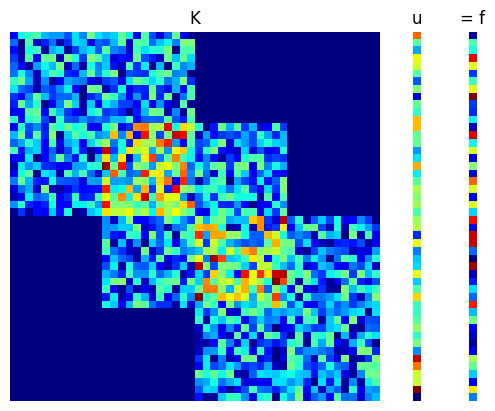

In [402]:
# Initialize a plot
fig, ax = plt.subplots(1, 3, figsize=(5, 4), constrained_layout = True, gridspec_kw={'width_ratios': [4, 0.5, 0.5]})
# Plot the matrix A
ax[0].imshow(dense_bsr, cmap="jet")
ax[0].set_title("K")
# ax[0].set_xlabel("Columns")
# ax[0].set_ylabel("Rows")
ax[1].imshow(soln, cmap="jet")
ax[1].set_title("u")
# ax[1].set_xlabel("1 column")
# ax[1].set_ylabel("Rows")
ax[2].imshow(rhs, cmap="jet")
ax[2].set_title("= f")
# ax[2].set_xlabel("1 column")
# ax[2].set_ylabel("=")
ax[0].axis("off")
ax[1].axis("off")
ax[2].axis("off")
# plt.tight_layout()
plt.show() 